<a href="https://colab.research.google.com/github/yvvvan/BMC_ELO/blob/main/ELO_trueskill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install trueskill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import csv
from pandas import Series,DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import copy
import itertools
from sklearn.cluster import KMeans
from trueskill import Rating
import trueskill


plt.rcParams['axes.unicode_minus']=False

## PlayYear Filter

In [3]:
filter_old = ["2019","2020","2021"]
filter_club_up = ["2022/1/","2022/2/","2022/3/","2022/4/","2022/5/"]
filter_2023 = ["2022/6/","2022/7/","2022/8/","2022/9/","2022/10/","2022/11/","2022/12/1","2022/12/8"]
filter_2022 = ["2023"]
filter = filter_old + filter_club_up

## Read Data

In [4]:
mahjong_game = {}
mahjong_player = {}

url = 'https://raw.githubusercontent.com/yvvvan/BMC_ELO/main/mahjong_riichi.csv'
df1 = pd.read_csv(url)
for index, row in df1.iterrows():
    if row['Date'][:4] in filter:
        continue
    elif row['Date'][:7] in filter:
        continue
    elif row['Date'][:8] in filter:
        continue
    elif row['Date'] in filter:
        continue
    else:
        date = row[1]
        id = row[2]
        player = int(row['PlayerId'])
        points = float(row['Points'])
        score = float(row['Score'])
        rank = int(row['Rank'])
        if id not in mahjong_game:
            mahjong_game[id]={}
            mahjong_game[id]["date"] = date
            mahjong_game[id]["result"] = {}
        if player not in mahjong_player:
            mahjong_player[player]={}
            mahjong_player[player]["r"] = 1200
            mahjong_player[player]["rs"] = [1200]
            mahjong_player[player]["i"] = 0
            mahjong_player[player]["s"] = []
            mahjong_player[player]["ranks"] = []
            mahjong_player[player]["lastplay"] = ""
        mahjong_player[player]["i"] += 1
        mahjong_player[player]["s"] += [score]
        mahjong_player[player]["ranks"] += [rank]
        mahjong_game[id]["result"][player] = (rank,points,score,mahjong_player[player]["i"])

url = 'https://raw.githubusercontent.com/yvvvan/BMC_ELO/main/mahjong_players.csv'
df2 = pd.read_csv(url)
for index, row in df2.iterrows():
    id = int(row['PlayerId'])
    name = row['Name']
    if id not in mahjong_player:
        continue
    mahjong_player[id]["n"] = name

In [5]:
mahjong_game["20230511ALKJ"]

{'date': '2023/5/11',
 'result': {2: (4, 12.3, -32.7, 59),
  78: (2, 33.0, 8.0, 9),
  65: (3, 22.6, -12.4, 15),
  13: (1, 52.1, 37.1, 78)}}

## Microsoft Trueskill

In [6]:
def get_r_value_all(mu=25, sigma=25/3, k=3):
    player_result = copy.deepcopy(mahjong_player)

    # initial Trueskill
    for p in player_result:
      player_result[p]["trueskill"] = Rating(mu=mu,sigma=sigma)
      player_result[p]["rs"] = [mu-k*sigma]

    for game in mahjong_game:

        players = []
        rank = []
        players_ts = []
        new_r = []
        
        for p in mahjong_game[game]["result"]: 
            players.append(p)
            players_ts.append((player_result[p]["trueskill"],))
            rank.append(mahjong_game[game]["result"][p][0])

        (new_r1,) , (new_r2,) , (new_r3,) , (new_r4,)  = trueskill.rate(players_ts, ranks=rank)
        new_ts = [new_r1, new_r2, new_r3, new_r4]

        for i in range(4):
            player_result[players[i]]["trueskill"] = new_ts[i]
            player_result[players[i]]['r'] = new_ts[i].mu - k * new_ts[i].sigma

            # decay for not active player
            if player_result[players[i]]["i"] < 5:
                player_result[players[i]]['r'] = new_ts[i].mu - 2 * k * new_ts[i].sigma
            elif player_result[players[i]]["i"] < 30:
                player_result[players[i]]['r'] = new_ts[i].mu - 1.5 * k * new_ts[i].sigma
            # elif player_result[players[i]]["i"] < 45:
            #     player_result[players[i]]['r'] = new_ts[i].mu - 1.5 * k * new_ts[i].sigma

            player_result[players[i]]['rs'] += [player_result[players[i]]['r']]
            player_result[players[i]]['sig'] = new_ts[i].sigma
            player_result[players[i]]['mu'] = new_ts[i].mu


    ranking = sorted(player_result, key = lambda i: player_result[i]['r'], reverse=True)
    r_results = {"Player":[],"R-Value":[],"#Hanchan":[],"mu":[],"sigma":[],"R-change":[]}
    for p in ranking:
        if p != 0:
            r_results["Player"].append(player_result[p]['n'])
            r_results["R-Value"].append(round(player_result[p]['r'],4))
            
            r_results["mu"].append(round(player_result[p]['mu'],4))
            r_results["sigma"].append(round(player_result[p]['sig'],4))

            r_results["#Hanchan"].append(player_result[p]['i'])
            r_results["R-change"].append(player_result[p]['rs'])
    return r_results

## Result

In [7]:
data = get_r_value_all(mu=25, sigma=25/3, k=3) # r = mu - k * sigma, microsoft的设定旨在使一开始时，r=0

df = pd.DataFrame(np.array([data["Player"],data["R-Value"],data["mu"],data["sigma"],data["#Hanchan"]]).T, columns=['Player', 'R-Value', 'μ', 'σ', '#Hanchan'])
pd.set_option('display.max_rows', df.shape[0]+1)
df

,Player,R-Value,μ,σ,#Hanchan
0,YF,25.2535,27.4918,0.7461,86
1,JY,24.7391,27.1068,0.7893,66
2,JL,24.5688,26.833,0.7547,84
3,WJ,24.0335,26.9796,0.982,36
4,ZK,23.8267,26.3083,0.8272,57
5,NRK,23.121,26.255,1.0447,33
6,PG,23.1041,26.2334,1.0431,31
7,SAM,22.9877,25.5986,0.8703,48
8,LX,22.8487,25.2447,0.7986,61
9,TM,22.8275,25.2941,0.8222,60


### Player R-Changes

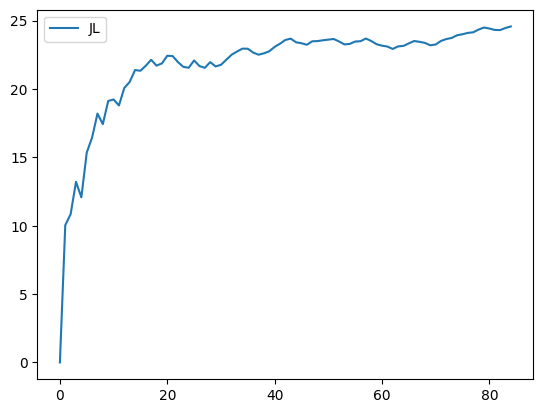

In [8]:
ps = ['JL']

d = get_r_value_all()
for (j,p) in enumerate(d["Player"]):
    if p not in ps:
        continue
    y = d["R-change"][j]
    plt.plot(range(len(y)),y, label="%s"%(p))

plt.legend()
plt.show()


### R-Value Boxplot

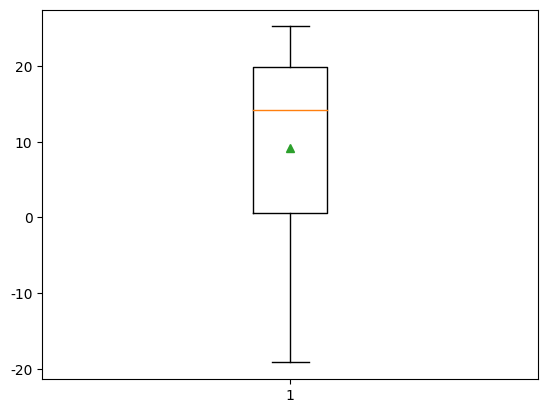

In [9]:
#@title All Players
plt.boxplot(data["R-Value"], showmeans=True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


8 13 12 36


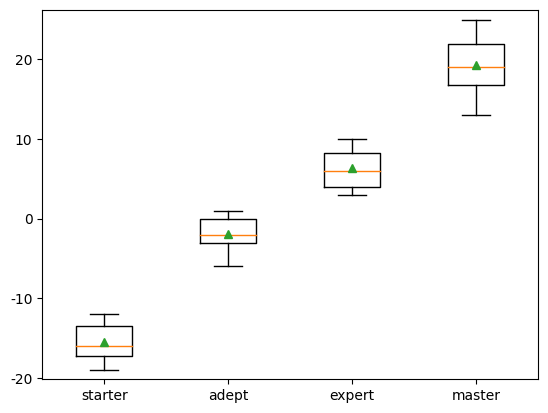

In [10]:
#@title Skill-Level(KMean)
x = data["R-Value"]
y = np.array(x).reshape(-1,1)
km = KMeans(n_clusters=4, random_state=1)
result = km.fit_predict(y)
r_min = min(x)-1
r_max = max(x)+1
# level
R_level={0:[],1:[],2:[],3:[]}
R_level_sorted={0:[],1:[],2:[],3:[]}
for i in range(len(result)):
    R_level[result[i]].append(int(y[i]))

R_level_mean = [np.mean(R_level[0]),np.mean(R_level[1]),np.mean(R_level[2]),np.mean(R_level[3])]
sorted_id = sorted(range(len(R_level_mean)), key=lambda k: R_level_mean[k])
for i in range(4):
    R_level_sorted[i] = R_level[sorted_id[i]]

R_level_name=["starter","adept","expert","master"]
print(len(R_level_sorted[0]),len(R_level_sorted[1]),len(R_level_sorted[2]),len(R_level_sorted[3]))

plt.boxplot([R_level_sorted[0],R_level_sorted[1], R_level_sorted[2], R_level_sorted[3]],showmeans=True)
plt.xticks(range(1,4+1),R_level_name)
plt.ylim((r_min,r_max))
plt.show()

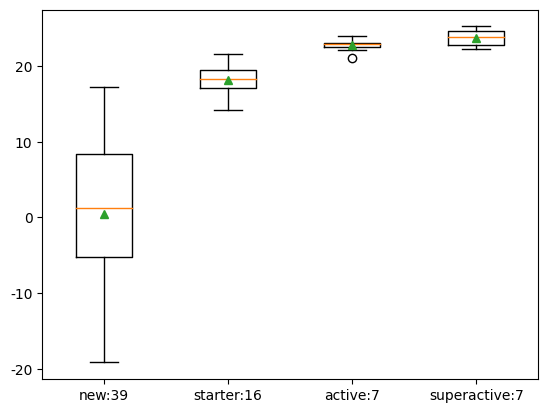

In [11]:
#@title Aktive Group
x = data["#Hanchan"]
y = data["R-Value"]
r_newplayer = []
r_midplayer = []
r_activeplayer = []
r_superactiveplayer = []
for i in range(len(y)):
    if x[i] < 10:
        r_newplayer.append(y[i])
    elif x[i] < 30:
        r_midplayer.append(y[i])
    elif x[i] < 55:
        r_activeplayer.append(y[i])
    elif x[i] < 10000:
        r_superactiveplayer.append(y[i])
z = ["new:%i"%len(r_newplayer), "starter:%i"%len(r_midplayer), "active:%i"%len(r_activeplayer), "superactive:%i"%len(r_superactiveplayer)]

plt.subplots_adjust(hspace = 0.3)
plt.boxplot([r_newplayer,r_midplayer, r_activeplayer, r_superactiveplayer], showmeans=True)
plt.xticks(range(1,len(z)+1),z)
plt.show()

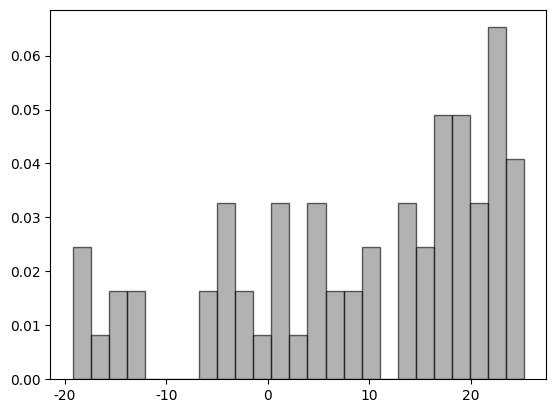

In [12]:
#@title Distribution
num_bins = 25
x = data["R-Value"]
mu = np.mean(x) 
sigma = np.std(x) 
n, bins, patches = plt.hist(x, num_bins,density=True, edgecolor="black",facecolor='gray', alpha=0.6)
#y = norm.pdf(bins, mu, sigma) 
#plt.plot(bins, y, 'g--') 
plt.show()

## Corelation

#### Tenhou Code

In [13]:
def calculate_R(rate, count, rank, score, rates_all, uma_type = 0, w=0.5, hanchan=60, q=20, correction=30):
    # 試合数補正 r
    #w = 0.2
    # if count < hanchan: #400
    #     w = 1 - count * (1-w)/hanchan #0.002

    # 対戦結果 u
    ## 天凤段位战
    if uma_type == 0:
        uma = [30, 10, -10, -30]
        u = uma[rank-1]
    
    ## 天凤雀庄战
    elif uma_type == 1:
        u = score
    
    ## 前30半庄补正10
    elif uma_type >= 2:
        u = score
        if count <= 30:
            u += correction

    # 補正値 b
    r_avg = sum(rates_all)/4
    if r_avg < 1500:
        r_avg = 1500
    r = rate
    ## 个人rate<1500时,补至1500
    if uma_type == 3 and r < 1500:
      r = 1500

    b = (r_avg - r)/q

    return rate+w*(u+b)

In [14]:
def get_r_value_all_tenhou(type=2, w=0.5, q=40, hanchan=60 , initial=900, correction=30):
    player_result = copy.deepcopy(mahjong_player)

    
    # initial 
    for p in player_result:
      player_result[p]["r"] = initial
      player_result[p]["rs"] = [initial]

    avg_p = {1:[],2:[],3:[],4:[]}
    for game in mahjong_game:
        
        players = []
        results = {}  # results := { id:(rank,points,score(uma),#hanchan) } 
        old_r = []
        new_r = []
        
        # get all date
        for p in mahjong_game[game]["result"]:
            players.append(p)
            results[p] = mahjong_game[game]["result"][p]
            # add score(uma) to rank-class -> to calculate the avg_score for each rank
            avg_p[mahjong_game[game]["result"][p][0]].append(mahjong_game[game]["result"][p][2]) 
            rate = player_result[p]["r"]
            old_r.append(player_result[p]["r"])

        # calculate new r for each player
        for p in mahjong_game[game]["result"]:
            #calculate_R(rate, count, rank, rates_all, score, uma_type = 0, w=0.4,q=20, hanchan=60)
            r = calculate_R(player_result[p]["r"], results[p][3], results[p][0], results[p][2], old_r, type, w, hanchan, q, correction)
            new_r.append(r)

        # update r
        for i in range(4):
            player_result[players[i]]["r"] = round(new_r[i])
            player_result[players[i]]["rs"] += [round(new_r[i])]

    # finished
    ranking = sorted(player_result, key = lambda i: player_result[i]['r'], reverse=True)
    r_results = {"Player":[],"R-Value":[],"#Hanchan":[],"R-change":[]}
    for p in ranking:
        if p != 0:
            r_results["Player"].append(player_result[p]['n'])
            r_results["R-Value"].append(round(player_result[p]['r']))
            r_results["#Hanchan"].append(player_result[p]['i'])
            r_results["R-change"].append(player_result[p]['rs'])
    r_results["avg"] = avg_p
    return r_results

In [22]:
data1 = get_r_value_all_tenhou(type=2, w=0.5, q=40, initial=900, correction=40)
data2 = get_r_value_all(mu=25, sigma=25/3, k=3)

df_tenhou = pd.DataFrame(np.array([data1["Player"],data1["R-Value"]]).T,columns=['Player', 'R-Tenhou'])
df_trueskill = pd.DataFrame(np.array([data2["Player"],data2["R-Value"],data2["sigma"],data2["#Hanchan"]]).T,columns=['Player', 'Trueskill','Sigma','#Hanchan'])

df = pd.merge(df_tenhou,df_trueskill,on=['Player'])
pd.set_option('display.max_rows', df.shape[0]+1)
df

,Player,R-Tenhou,Trueskill,Sigma,#Hanchan
0,JL,1764,24.5688,0.7547,84
1,YF,1758,25.2535,0.7461,86
2,JY,1723,24.7391,0.7893,66
3,WJ,1721,24.0335,0.982,36
4,ZK,1643,23.8267,0.8272,57
5,NRK,1632,23.121,1.0447,33
6,CH,1623,22.8108,0.9713,41
7,PG,1611,23.1041,1.0431,31
8,TM,1599,22.8275,0.8222,60
9,SAM,1596,22.9877,0.8703,48


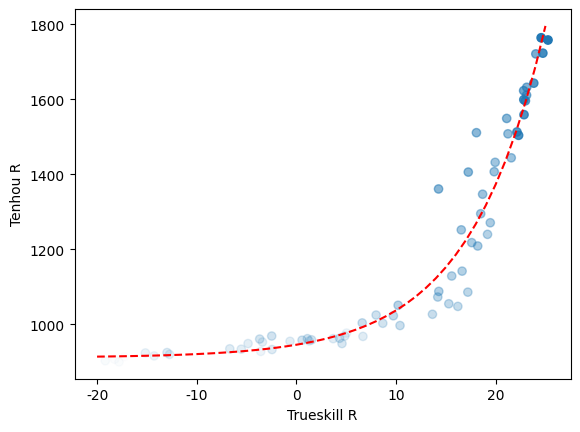

In [23]:
from scipy.optimize import curve_fit
 
def func(x, a, b, c):
    return a**(x+c) + b

x_min = int(min(np.array(df['Trueskill'],dtype='float')))-1
x_max = int(max(np.array(df['Trueskill'],dtype='float')))+1
hanchan = np.array(df['#Hanchan'],dtype='float')
sigma = np.array(df['Sigma'],dtype='float')
k = 0.1
alpha = 1-(sigma-np.min(sigma)+k)/(np.max(sigma)+k-np.min(sigma))
beta = hanchan/np.max(hanchan)
plt.scatter(np.array(df['Trueskill'],dtype='float'),np.array(df['R-Tenhou'],dtype='int'),alpha=alpha/3+beta*2/3)
popt, pcov = curve_fit(func, np.array(df['Trueskill'],dtype='float'), np.array(df['R-Tenhou'],dtype='int'))
#popt数组中，三个值分别是待求参数a,b,c
y2 = [func(i, popt[0],popt[1],popt[2]) for i in range(x_min,x_max)]
plt.plot(range(x_min,x_max),y2,'r--')
plt.xlabel("Trueskill R")
plt.ylabel("Tenhou R")

plt.show()

In [17]:
popt, pcov

(array([  1.13889564, 911.57856696,  27.16426346]),
 array([[ 1.20390647e-04,  1.28924561e-01, -4.18313581e-02],
        [ 1.28924561e-01,  2.63213177e+02, -4.65905887e+01],
        [-4.18313581e-02, -4.65905887e+01,  1.45849721e+01]]))

## Other

In [18]:
df = pd.merge(df1,df2,on=['PlayerId'])
pd.set_option('display.max_rows', df.shape[0]+1)

In [19]:
new_df = pd.merge(df.groupby(['Name']).mean(numeric_only=True)[['Points','Score','Rank']],df.groupby(['Name'])['Id'].count(),on=['Name'])

In [20]:
new_df = new_df.rename(columns={'Id': 'Count'})
new_df[new_df.Count>=10].sort_values('Points',ascending=False)

,Points,Score,Rank,Count
Name,,,,
G,37.316667,10.650000,2.166667,18
WJ,35.844444,8.622222,2.222222,36
KRS,35.431579,8.852632,2.157895,19
WEI,34.369231,6.292308,2.307692,13
GW,34.363636,11.181818,1.818182,11
JY,34.087879,6.512121,2.257576,66
JL,34.034118,8.105882,2.141176,170
ISA,33.930435,5.017391,2.391304,23
YF,33.667442,7.330233,2.127907,86


In [21]:
df[df.Name=='YF'][['Name','Rank','Id']].groupby(['Name','Rank']).count()

Id
Name Rank    
YF   1     27
     2     32
     3     16
     4     11